In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import os
folder_name = "models"
def load_model_helper(name):
    files = os.listdir(folder_name)
    for f in files:
        if name in f:
            return load_model("{}/{}".format(folder_name,f))

In [3]:
coin_name = 'raiden-network-token'
model = load_model_helper("{}_".format(coin_name))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [4]:
from coinmarketcap_draw import coinmarketcap_data

In [5]:
data = coinmarketcap_data(coin_name)

In [6]:
import bulbea as bb
figsize = (20, 15)
% matplotlib inline
share = bb.Share("123",'123',data=data)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


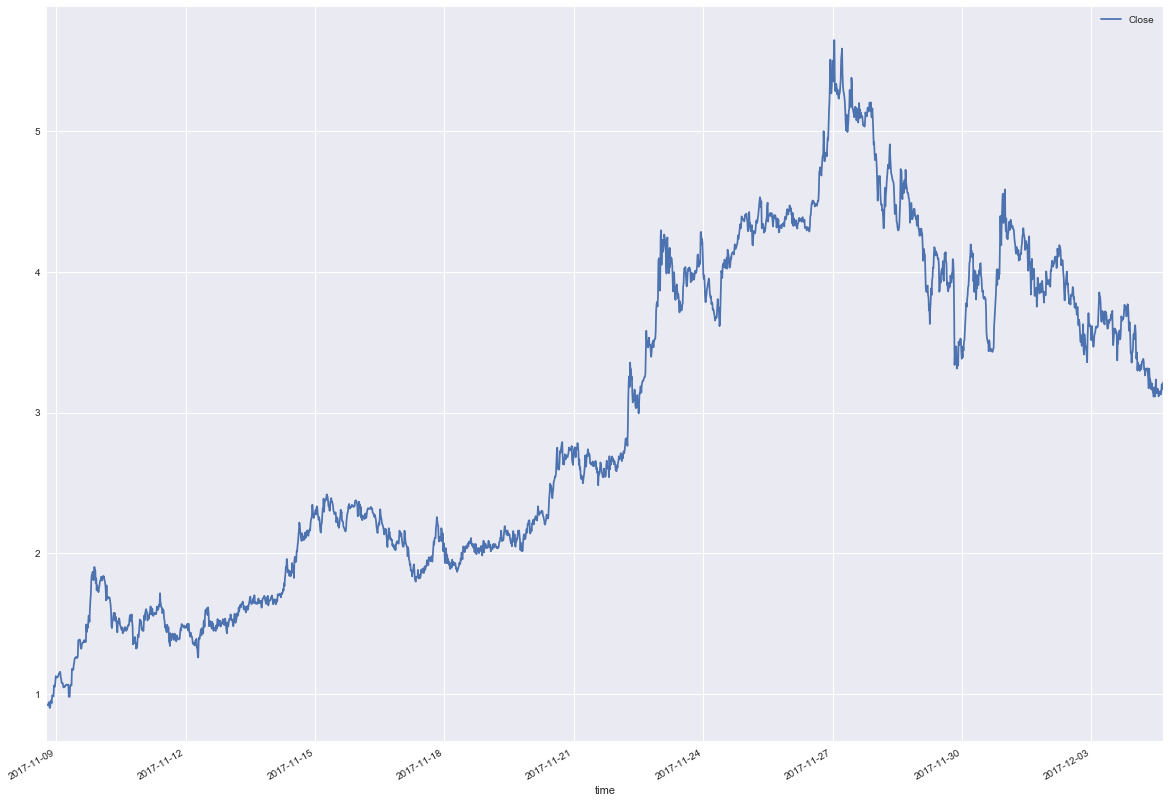

In [7]:
share.plot(figsize = figsize)

In [8]:
from bulbea.learn.evaluation import split
import numpy as np

In [9]:
_, Xtest, _, ytest = split(share, 'Close', normalize = True, train = 0.0)
_,ori_Xtest,_,ori_ytest = split(share, 'Close', normalize = False, train = 0.0)
Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

print(Xtest.shape)
print(ytest.shape)

(2459, 24, 1)
(2459,)


In [10]:
# last_n = -500
# print(len(Xtest))
# Xtest = Xtest[last_n:]
# ytest = ytest[last_n:]
# ori_Xtest = ori_Xtest[last_n:]
# ori_ytest = ori_ytest[last_n:]
# print(len(Xtest))

In [11]:
predicted = model.predict(Xtest)
print(predicted.shape)

(2459, 1)


In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, predicted)

0.00099969168335106197

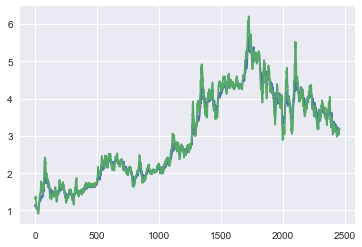

In [13]:
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return

def rever_back(ori_ytest,predicted):
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))
    return new_pre

new_pre = rever_back(ori_ytest,predicted)

pplt.plot(ori_ytest)
pplt.plot(new_pre)
pplt.show()

In [43]:
from datetime import timedelta
import pandas as pd


def predict_n_day_of_futures(n,share):
    _, Xtest, _, ytest = split(share, 'Close', normalize = True, train = 0.0)
    _,ori_Xtest,_,ori_ytest = split(share, 'Close', normalize = False, train = 0.0)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

    # Format the Xtest
    last_Xtest = Xtest[-1:]
    last_Xtest  = np.reshape(last_Xtest, (last_Xtest.shape[0], last_Xtest.shape[1], 1))
    
    # Format the ori_ytest
    last_ori_ytest = ori_ytest[-1]
    
    # Get the prediction
    predict = model.predict(last_Xtest)
    
    # convert it back
    new_pre = rever_back([last_ori_ytest],[predict])[0][0][0]
    
    # Append the new data
    new_time = data.iloc[-1].name + timedelta(hours=1)
    s = pd.Series({"Close":new_pre}, name=new_time)
    new_data = data.append(s)
    print(new_data)

In [44]:
predict_n_day_of_futures(1,share)

                      market_cap  price_btc  price_usd  volume_usd  \
2017-11-08 19:04:33          0.0   0.000126   0.920038    420014.0   
2017-11-08 19:19:32          0.0   0.000125   0.918429    419280.0   
2017-11-08 19:34:32          0.0   0.000126   0.920529    420239.0   
2017-11-08 19:49:31          0.0   0.000126   0.935027    426857.0   
2017-11-08 20:04:32          0.0   0.000129   0.940030    429141.0   
2017-11-08 20:19:30          0.0   0.000125   0.902648    501618.0   
2017-11-08 20:34:32          0.0   0.000125   0.898916    499544.0   
2017-11-08 20:49:33          0.0   0.000126   0.917675    506740.0   
2017-11-08 21:04:30          0.0   0.000131   0.951025    539975.0   
2017-11-08 21:19:30          0.0   0.000130   0.941417    534520.0   
2017-11-08 21:34:33          0.0   0.000128   0.932699    529570.0   
2017-11-08 21:49:29          0.0   0.000136   0.987999    583458.0   
2017-11-08 22:04:30          0.0   0.000136   0.987699    583281.0   
2017-11-08 22:19:29 